In [1]:
import os
try:
    os.chdir(os.path.join(os.getcwd(), '../..'))
except:
    pass

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')
                        
data = pd.read_csv('data/raw/pdss_data/compiled.csv')

# Définition d'une avance sur paiement pour le programme RBF du PDSS

Grégoire Lurton  - [@grlurton](https://twitter.com/grlurton)

Dans le cadre du programme RBV implémenté par le PDSS, on souhaite avoir la possibilité de faire des paiements au Formations Sanitaires avant d'avoir finalisé la validation des donnés. Cette souplesse serait permettrait de limiter les retards de paiement aux FOSAs, et par conséquent les problèmes de trésorerie qui peuvent en découler.

Pour décider quelle règle mettre en oeuvre pour définir ces avances sur paiement, on simule l'implémentation de différentes règles sur des données historiques disponibles dans ORBF. Spécifiquement, cette analyse utilise les données ORBF du PDSS du quatrième trimestre 2017 au premier trimestre 2019.

## Rapide description des données

In [3]:
def compute_payment(data):
    claimed = sum(data.claimed_value * data.tarif)
    validated = sum(data.validated_value * data.tarif)
    return pd.DataFrame({"claimed":[claimed], "validated":[validated]})

payments = data.groupby(["province","zone","aire","fosa", "year","quarter"]).apply(compute_payment)
payments = payments.reset_index()
payments["period"] = payments.year.astype(str) + payments.quarter.astype(str)

payments = payments[payments.period > "20173"]

print("N payments : " + str(len(payments)))
print("Median payments : " + str(payments.validated.median()))
print("Maximum payments : " + str(payments.validated.max()))

payments["overclaim_ratio"] = payments.claimed/payments.validated
print("Average Overclaim Ratio : " + str(payments.overclaim_ratio[payments.validated > 0].mean()))
print("Overclaim Ratio Higher Quantiles : " + str(payments.overclaim_ratio.quantile([.5,.75,.85, .90,.95])))

N payments : 9937
Median payments : 2249.3
Maximum payments : 36213.4
Average Overclaim Ratio : 9.48448648430564
Overclaim Ratio Higher Quantiles : 0.50     1.602250
0.75     2.392737
0.85     3.487607
0.90     5.700777
0.95    24.526793
Name: overclaim_ratio, dtype: float64


Les données sont composées de 9937 paiements. Le paiement médian était de 2250 USD, et le maximum était de 36213 USD. Dans 50% des cas, les données déclarées surestimaient les données validées de moins de 60%. Dans 10% des cas, les données déclarées représentaient plus de 5,7 fois la valeur finalement validées, et dans 5% des cas, les données déclarées étaient plus de 24 fois les données validées.

Ce n'est pas le but de l'analyse actuelle, mais on peut cependant penser que ces valeurs extrêmes doivent être repérables dans le cadre d'une vérification basées sur les risques. 

# Définition et simulation des règles

## Paramètres d'optimisation des règles

On simule des règles en cherchant à limiter deux types de risque:

* __Risque de sous-financement :__ L'objectif principal des avances sur paiement est de limiter le risque que les formations sanitaires se trouvent en difficultés financières dues au retard des financements. Dans ce cadre, on souhaite utiliser des règles qui permettent de limiter le risque de sous-financement. On définit ce risque comme la proportion de FOSA qui toucheraient une avance de paiement inférieure à une proportion fixée du paiement finalement validé. Dans cette analyse, on fixe cette proportion à 25% .

* __Risque de surpaiement :__ Dans le même temps, on cherche à limiter le risque financer lié au fait de faire des paiements sur des données non validées. Dans ce cadre, on se place dans un scénario où les FOSA ne remboursent pas le trop-perçu sur les avances dans les cas où les paiements validés sont inférieurs aux avances sur paiement. On définit en calculant le ratio entre les paiements trop perçus et les paiements validés. Par exemple, dans 10 sites le paiement validé pour chaque site est de 2000 USD et une avance de 1800 USD avait été fixée pour tous les sites, sauf un pour lequel l'avance payée avait été de 2400 USD. Le paiement total validé est donc de 20000 USD, le paiement effectué est de 2400 USD, le risque de surpaiement est évalué à 400 / 20000 = 2% 

In [4]:
def compute_advance_payments(data, rule):
    """Computes the advance payment to be made to a FOSA based on previous validated payments for each period
    
    Parameters
    -----------
    data: DataFrame
        DataFrame with a column period and a column validated
    rule: Function
        A function that takes the past validated payments as an argument, and returns a unique value for advance payment
    """
    advance_payments = []
    periods = data.period.unique()
    periods.sort()
    for period in periods[1:]:
        data_ante = data[data.period < period]
        advance_payment = rule(data_ante)
        advance_payments.append(advance_payment)
    out = pd.DataFrame.from_dict({"period":periods[1:], 
                                  "advance_payments":advance_payments})
    return out

def simulate_advance_payments(data, rule):
    """Simulates advance payments for all FOSAs
     
    A wrapper that computes the payments for each FOSA.
     
    Parameters
    -----------
    data: DataFrame
        DataFrame with a column period and a column validated as well as province, zone, aire and fosa
    rule: Function
        A function that takes the past validated payments as an argument, and returns a unique value for advance payment
    """
    simulation = data.groupby(["province","zone","aire","fosa"]).apply(compute_advance_payments, rule)
    simulation = simulation.reset_index()
    out = data.merge(simulation)
    return out

def benchmark(simulated, underfin_rate):
    """Computes benchmarking metrics 
     
     A wrapper that computes the payments for each fosa.
    
     Computing benchmarking metrics based on the result of simulations from simulate_advance_payments. For now we use 2 metrics
     
     under-financing risk: The proportion of FOSAs that would have received an advance payments lower than a 
         percentage fixed as underfin_rate, that is considered necessary for proper functioning.
     over-payment risk: The proportion of overpayments finally made in a scenario where FOSAs don't reimburse the 
         overpayments made in the advance payments.
    """
    simulated = simulated.dropna()
    advance_ratio = simulated.advance_payments / simulated.validated
    underfin = sum(advance_ratio < underfin_rate) / len(advance_ratio)
    overfin_val = sum(simulated.advance_payments[simulated.advance_payments > simulated.validated] - simulated.validated[simulated.advance_payments > simulated.validated])
    overfin_ratio = overfin_val / sum(simulated.validated.dropna())
    return (underfin, overfin_ratio)

### Règles testées

Les règles testées dans cette analyse ont été proposées par les équipes du PDSS et de Bluesquare. On a pour l'instant simulé les résultats de trois types de règles:

__Règles basées sur le minimum :__ Un premier type de règles est basé sur le paiement minimal qui a été validé pour la FOSA. Ce paiement est ajusté en ajoutant des multiples de la déviation standard des paiement validés, pour limiter le risque de sous-financement dans le cas de FOSA ayant connu des périodes avec des paiements validés particulièrement faibles.

__Règles basées sur la médiane :__ Un second type de règles est basé sur le paiement médian qui a été validé pour la FOSA. Ce paiement est ajusté en soustrayant des multiples de la déviation standard des paiement validés, pour limiter le risque de surpaiement.

__Règles basées sur le dernier paiement :__ Une troisème approche est de fixer l'avance sur paiement comme une proportion du dernier paiement validé pour la FOSA. Cela permet de baser l'avance sur les volumes de financement les plus récents pour les formations sanitaires.

On implémente chacune de ces règles en utilisant différentes valeurs pour les paramètres entrant en jeu (nombre de déviations standards additionnées ou soustraites, proportion du dernier paiement). On simule les avances sur paiements qui auraient été faites pour chaque FOSA pour chaque trimestre si chacune de ces règles avait été mise en oeuvre, et on estime chacun des risques pris en compte en fonction des résultats de l'ensemble de ces simulations.

In [5]:
## Advance = minimum payment made to the FOSA + k*std
def min_plus_sd(data_ante, k):
    return min(data_ante.validated) + k*np.std(data_ante.validated)

## Advance = median payment made to the FOSA - 1std
def median_minus_sd(data_ante,k):
    return max(np.median(data_ante.validated) - k*np.std(data_ante.validated), 0)

## PDSS = 60% of previous
def pdss(data_ante, rate):
    return rate * data_ante.loc[data_ante.period == max(data_ante.period), "validated"].values[0]

In [6]:
underfin_rate = .25

std_values = [.5, 1, 1.5, 2, 2.5, 3]


col=0
out = pd.DataFrame()
for std in std_values:
    min_simul = simulate_advance_payments(payments, lambda x : min_plus_sd(x, std))
    med_simul = simulate_advance_payments(payments, lambda x : median_minus_sd(x, std))
    min_quarter_benchmark = min_simul.groupby("period").apply(benchmark, underfin_rate)
    min_benchmark = benchmark(min_simul, underfin_rate)
    med_quarter_benchmark = med_simul.groupby("period").apply(benchmark, underfin_rate)
    med_benchmark = benchmark(med_simul, underfin_rate)
    
    algos = ["min +" + str(std) + " std"] * (len(min_quarter_benchmark) + 1) + ["median -" + str(std) + " std"] * (len(med_quarter_benchmark) + 1)
    base = ["min"] * (len(min_quarter_benchmark) + 1) + ["median"] * (len(med_quarter_benchmark) + 1)
    underfins = min_quarter_benchmark.apply(lambda x : x[0]).tolist() + [min_benchmark[0]] + med_quarter_benchmark.apply(lambda x : x[0]).tolist() + [med_benchmark[0]]
    overfins = min_quarter_benchmark.apply(lambda x : x[1]).tolist() + [min_benchmark[1]] + med_quarter_benchmark.apply(lambda x : x[1]).tolist() + [med_benchmark[1]]
    quarter = min_quarter_benchmark.index.tolist() +  ["overall"] + med_quarter_benchmark.index.tolist() + ["overall"]
    out = out.append(pd.DataFrame.from_dict({"algo":algos, "underfin":underfins, "overfin":overfins, 
                                             "quarter":quarter,
                                             "col":col, "base":base}))
    col = col + 1

In [7]:
pdss_rates = [0.4, 0.5, 0.6, 0.7, 0.8]
for rate in pdss_rates:
    pdss_simul = simulate_advance_payments(payments, lambda x : pdss(x, rate))
    pdss_quarter_benchmark = pdss_simul.groupby("period").apply(benchmark, underfin_rate)
    pdss_benchmark = benchmark(pdss_simul, underfin_rate)
    
    underfins = pdss_quarter_benchmark.apply(lambda x : x[0]).tolist() + [pdss_benchmark[0]]  
    overfins = pdss_quarter_benchmark.apply(lambda x : x[1]).tolist() + [pdss_benchmark[1]]
    quarter = pdss_quarter_benchmark.index.tolist() +  ["overall"]
    
    out = out.append(pd.DataFrame.from_dict({"algo":"Last payment - " + str(rate), "underfin":underfins, 
                                             "overfin":overfins, "quarter":quarter,
                                             "col":col, "base":"last_payment"}))
    col = col + 1

### Résultats des simulations

(0, 1)

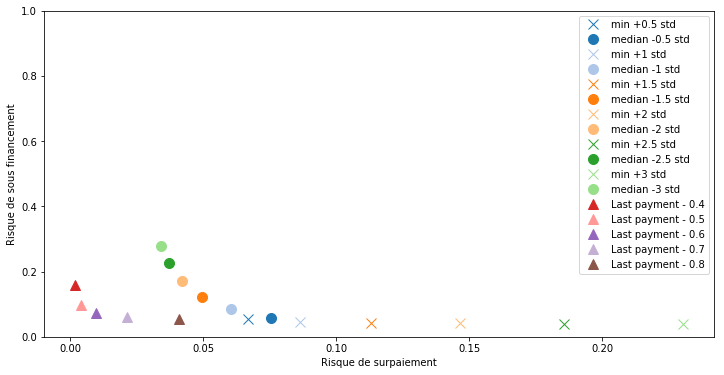

In [8]:
cmap = matplotlib.cm.get_cmap('tab20').colors
plot_quarter = False

fig1 = plt.figure(figsize = [12,6])
for algo in out.algo.unique():
    algo_data = out[out.algo == algo]
    for quarter in algo_data.quarter.unique() :
        to_plot = algo_data[algo_data.quarter == quarter]
        marker = "o"
        if to_plot.base.values[0] == "min":
            marker = "x"
        if to_plot.base.values[0] == "last_payment":
            marker = "^"
        if quarter == "overall":
            plt.plot(to_plot.overfin, to_plot.underfin, color = cmap[to_plot.col.values[0]], marker = marker, 
                     label = algo, linestyle = 'None', markersize = 10)
        if ~(quarter == "overall") & (plot_quarter == True):
            plt.plot(to_plot.overfin, to_plot.underfin, color = cmap[to_plot.col.values[0]], marker = marker, 
                     linestyle = 'None', alpha = .5, markersize = 5)
plt.legend()
plt.ylabel("Risque de sous financement")
plt.xlabel("Risque de surpaiement")
plt.ylim(0,1)

Ces simulations permettent d'obtenir un résultat assez clair. On voir que les règles basés un proportion de la dernière valeur ont les meilleurs résultats. Utiliser un taux d'actualisation .70 permet de limiter le risque de sous financement à moins de 5% tout en limitant le risque de surfinancement aux alentours de 2%. Les stratégies basées sur le mimimum ou la médiane se trouvent sur une courbe de performance différente, avec un risque de sous-financement beaucoup plus large, pour un même risque de surpaiement. La faiblesse de ces approches est donc probablement liée à une forte variabilité des paiements dans le temps, ce qui rend difficile l'idée de se baser sur les caractéristiques statistiques des distributions.